# Multiple Linear Regression

In this notebook we will expand our simple linear regression model that we built to predict car prices in the last chapter to include several independent variables in order to produce better predictions.

### Package and Data Loading

As before, we will import the required packages and our car price data set.

In [1]:
import pandas as pd
import matplotlib.pyplot as plot
import statsmodels.api as stats
import numpy as np

In [2]:
carprice_df = pd.read_csv('CarPrice_Assignment.csv')

### Assessing the Data

In [3]:
carprice_df.shape

(205, 26)

In [4]:
carprice_df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


We can see all the columns and what data type they are using [df.info()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) and how many unique values there are for the categorical types using [df.nunique()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html).

In [5]:
carprice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Here we are checking the number of unique values in specifically the categorical variables using [df.select_dtypes()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html)

In [6]:
carprice_df.select_dtypes(include='object').nunique()

CarName           147
fueltype            2
aspiration          2
doornumber          2
carbody             5
drivewheel          3
enginelocation      2
enginetype          7
cylindernumber      7
fuelsystem          8
dtype: int64

As we can see, the data contains a mixture of numeric types and categorical (object) types. We will remove the car_ID field from the data as this is only an identifier. For the purposes of this lesson we will also remove CarName from the data as it contains a large number of unique values (How could we extract more useful information from this variable?).

In [7]:
carprice_df = carprice_df.drop(columns=['car_ID', 'CarName'])

## Basic Multiple Regression Model

Before we build our full model using all of the data available to us in the dataset we will first build a straightforward model using four independent variables we think might be relevant to the price to practice fitting the model. The actual fitting of the model is very similar to how we did it previously for the simple linear regression model using statsmodels. We will build it using enginesize from the simple model plus curbweight, peakrpm and citympg.

In [8]:
Y_basic = carprice_df.price
X_basic = stats.add_constant(carprice_df[['enginesize', 'curbweight', 'peakrpm', 'citympg']])

The only difference to the previous chapter is that we add a constant column to our dataframe of multiple independent variables instead of to a single independent variable. The fitting process is also exactly the same.

In [9]:
model_basic = stats.OLS(Y_basic, X_basic)
results_basic = model_basic.fit()

We can see our results and the parameters for each of the independent variables using the .summary() attribute again.

In [10]:
print(results_basic.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     225.0
Date:                Sun, 25 Sep 2022   Prob (F-statistic):           7.62e-73
Time:                        15:42:05   Log-Likelihood:                -1957.7
No. Observations:                 205   AIC:                             3925.
Df Residuals:                     200   BIC:                             3942.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.022e+04   5937.020     -5.090      0.0

With these parameter values we can construct our model:

$\textrm{price}=116*\textrm{enginesize}+ 5.7*\textrm{curbweight}+2.7*\textrm{peakrpm}+10.8*\textrm{citympg}-30220$

## Full Multiple Regression Model

We can now look at building our final model using the full range of features available to us. Before we build the model we need to prepare the data and reduce the number of independent variables we have.

We can look at the correlations between different numerical variables in a handy way using a correlation matrix - this allows us to see the correlation between all pairs of variables at once. We can then remove some of the independent variables that are highly correlated and would cause problems with the algorithm due to multicollinearity. We can create this correlation matrix using the [df.corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method. We add a red/blue heatmap to better see where the extreme correlations are.

In [11]:
carprice_df.select_dtypes(exclude='object').corr().style.background_gradient(cmap='coolwarm')

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
symboling,1.000000,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,-0.035823,0.034606,-0.079978
wheelbase,-0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,-0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,-0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,-0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,-0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,-0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.008735,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443
compressionratio,-0.178515,0.249786,0.158414,0.181129,0.261214,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,0.324701,0.265201,0.067984


We can see that highwaympg and citympg are highly correlated with a correlation coefficient of 0.97. Removing highwympg will get rid of this correlation and help reduce the complexity of our model. We also choose to remove carlength and carwidth to remove some more high correlations. 

In [12]:
carprice_df = carprice_df.drop(columns=['carlength', 'carwidth', 'highwaympg'])

#### One Hot Encoding

We can also use the categorical data by one-hot-encoding the it. This is where we make each category in a categorical variable its own independent variable which has a binary 1/0 value. We use the function [pd.get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to do this for the categorical values and then join them back to the numerical variables using [pd.concat()](https://pandas.pydata.org/docs/reference/api/pandas.concat.html). We drop the first value to prevent multicollinearity. 

In [13]:
dummy = pd.get_dummies(carprice_df.select_dtypes(include='object'), drop_first=True)

In [14]:
carprice_df = pd.concat([carprice_df.select_dtypes(exclude='object'), dummy], axis=1)

We can repeat the above process where we remove highly correlated variables, now including the one hot encoded features.

In [15]:
carprice_df.corr().style.background_gradient(cmap='coolwarm')

,symboling,wheelbase,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
symboling,1.000000,-0.531954,-0.541038,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,-0.035823,-0.079978,0.194311,-0.059866,0.664073,0.168845,0.435648,-0.378341,-0.298243,0.102839,-0.076381,0.212471,0.009347,-0.133979,-0.082855,0.037513,-0.013597,0.245950,-0.090188,-0.034161,-0.000238,0.065707,-0.047012,0.245950,-0.034069,0.212471,-0.194311,0.122067,0.012532,0.181939,0.065707
wheelbase,-0.531954,1.000000,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,0.577816,-0.308346,0.257611,-0.447357,-0.008608,-0.386094,0.291086,0.210899,-0.460355,0.498830,-0.187790,-0.004156,0.399603,-0.204037,-0.183195,0.166152,-0.081174,0.261182,-0.309492,0.145842,-0.120709,0.037803,-0.081174,-0.396505,-0.070124,0.308346,-0.033294,0.348891,-0.117359,-0.032129
carheight,-0.541038,0.589435,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,0.119336,-0.284631,0.087311,-0.552208,-0.072328,-0.477476,0.235863,0.459148,-0.100273,0.039814,-0.106234,-0.092628,0.319687,0.036260,-0.046670,-0.065063,-0.238720,0.152982,0.059696,-0.049777,-0.015076,-0.170181,-0.238720,-0.079418,-0.206225,0.284631,-0.101245,0.108685,-0.278615,-0.066778
curbweight,-0.227691,0.776386,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,0.835305,-0.217275,0.324902,-0.197379,0.098956,-0.287501,0.099425,0.164075,-0.666039,0.669987,0.050468,0.109243,0.250124,-0.413293,-0.080295,0.400878,-0.039196,0.264554,-0.576463,0.405490,-0.143903,0.187964,-0.039196,-0.577159,-0.040801,0.217275,0.034431,0.520220,-0.002434,0.024052
enginesize,-0.105790,0.569329,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,0.874145,-0.069594,0.108217,-0.020742,0.239363,-0.216805,0.088459,-0.027518,-0.518391,0.565509,0.196826,0.128248,0.016063,-0.363334,-0.016508,0.562403,-0.184762,0.144878,-0.631431,0.511783,-0.111081,0.335555,-0.184762,-0.442562,-0.166946,0.069594,0.049033,0.483520,0.004490,-0.013327
boreratio,-0.130051,0.488750,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,0.553173,-0.054451,0.212614,-0.119258,0.208089,-0.227032,0.030517,0.105719,-0.583087,0.574105,0.185042,0.158136,0.181729,-0.410383,0.326798,0.119509,0.000127,-0.007797,-0.164076,0.128365,-0.108774,0.054482,0.000127,-0.353342,0.000110,0.054451,0.070030,0.419335,-0.004213,0.025977
stroke,-0.008735,0.160959,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,0.079443,-0.241829,0.222982,0.011082,0.043215,0.052316,0.035630,-0.095084,0.124397,-0.022325,-0.138455,-0.032545,-0.084688,0.366084,-0.522808,-0.044813,-0.000187,0.176485,-0.111046,0.068388,-0.050450,-0.110878,-0.000187,-0.234866,-0.000162,0.241829,0.144263,-0.110280,0.251259,-0.005688
compressionratio,-0.178515,0.249786,0.261214,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,0.324701,0.067984,-0.984356,0.295541,-0.177888,0.029623,-0.202650,0.188286,0.016315,-0.062683,0.105185,-0.019762,-0.002519,0.219153,0.027545,-0.084328,-0.086649,-0.026436,0.173360,-0.012522,-0.065559,-0.011354,0.023986,-0.026436,-0.183384,-0.022838,0.984356,-0.055528,-0.311035,-0.153726,-0.016654
horsepower,0.070873,0.353294,-0.108802,0.750739,0.809769,0.573677,0.080940,-0.204326,1.000000,0.131073,-0.801456,0.808139,0.163926,0.241685,0.126947,0.194801,-0.053770,-0.024097,-0.063081,-0.544438,0.57

In [16]:
carprice_df = carprice_df.drop(columns=['compressionratio', 'drivewheel_fwd', 'enginetype_rotor', 'fuelsystem_4bbl', 'fuelsystem_idi'])

In [17]:
carprice_df.shape

(205, 36)

We now have 35 independent variables (plus our target variable price) to use in our regression model.

### Test/Train Split

As in the previous notebook, we will split our data with 70% into the training set and the remaining 30% into the test set. 

In [18]:
train_df=carprice_df.sample(frac=0.7, random_state=99) #random state is a seed value
test_df=carprice_df.drop(train_df.index)

In [19]:
train_df.shape

(144, 36)

In [20]:
test_df.shape

(61, 36)

### Fitting the Linear Regression Model

We once again use statsmodels to fit our linear regression model. We do this in the same way as the previous notebook except now our X_train contains all of our independent variables (plus the constant column).

In [21]:
Y_train = train_df.price
X_train = stats.add_constant(train_df.drop(columns=['price']))

In [22]:
model_carprice = stats.OLS(Y_train, X_train)
results_carprice = model_carprice.fit()

In [23]:
print(results_carprice.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     48.60
Date:                Sun, 25 Sep 2022   Prob (F-statistic):           1.43e-51
Time:                        15:42:36   Log-Likelihood:                -1299.3
No. Observations:                 144   AIC:                             2669.
Df Residuals:                     109   BIC:                             2773.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -1.11e+

For example here we can see that enginelocation_rear has a coefficient of 7389 so when everything else is constant, a car with the engine in the rear we predict will cost an extra \\$7389 than a car with the engine in the front on average. Also we predict that for every unit of weight heavier a car is, the car will cost an extra $3.3. In this state we cannot compare the coefficients to one another as they all have different units - it makes no sense to compare pounds in curbweight with rpm in peakrpm! 

Our sum of square residuals is then:

In [24]:
print('The sum of square residuals is {:.1f}'.format(results_carprice.ssr))

The sum of square residuals is 579728377.8


In our simple linear regression in the last notebook we found a value of 2.3 billion for the SSE whereas here our value is 0.5 billion. As we are training our model on the same number of datapoints, we can see that the multiple linear regression is producing a smaller total error.

We can also use our test set to compare our predictions with the observed values.

In [25]:
Y_test = test_df.price
test_df = stats.add_constant(test_df)
X_test = test_df[X_train.columns]

In [26]:
test_predictions = results_carprice.predict(X_test)

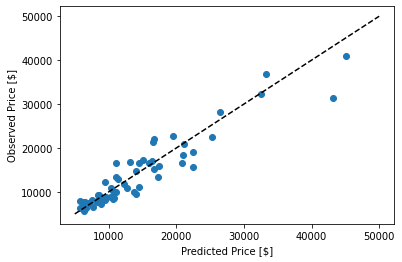

In [27]:
plot.scatter(test_predictions, Y_test)
plot.plot([5000, 50000], [5000, 50000], c='k', ls='--')
plot.xlabel('Predicted Price [$]')
plot.ylabel('Observed Price [$]')
plot.show()

Plotting our predicted prices against the observed values again we can see that the points are much tighter to the diagonal line that previously for the simple linear regression model. We will explore the coefficients that we calculate in our model and the metrics used to evaluate them more in the next chapter.

## Scikit-Learn

Again we can repeat this exercise using Scikit-Learn

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Test/Train Split

When we have multiple independent variables, we do not need to reshape our X array as it is already a 2D array. We can therefore insert our training independent variables straight into the fitting method.

In [29]:
Y = carprice_df.price
X = carprice_df.drop(columns=['price'])

In [30]:
sk_X_train, sk_X_test, sk_Y_train, sk_Y_test = train_test_split(X, Y, test_size=0.3, random_state=99)

In [31]:
regressor = LinearRegression()  
regressor.fit(sk_X_train, sk_Y_train)

LinearRegression()

In [32]:
sk_intercept_carprice = regressor.intercept_
sk_engsize_coeffs = regressor.coef_
sk_ssr_carprice = np.sum((sk_Y_train-regressor.predict(sk_X_train))**2)

Unlike the statsmodels version, the LinearRegression class does not supply a convenient summary of the best fit coefficients however the coefficients are ordered in the same order as the columns are in our X array. We can combine the column names and coefficient values in a pandas Series to better read the values.

In [33]:
pd.Series(sk_engsize_coeffs, index=sk_X_train.columns)

symboling                2.523350e+02
wheelbase                7.412976e+01
carheight                8.309020e+01
curbweight               4.839412e+00
enginesize               1.715172e+02
boreratio               -5.949063e+03
stroke                  -6.214262e+03
horsepower               2.217799e+01
peakrpm                  2.154338e+00
citympg                  4.212092e+01
fueltype_gas            -1.110769e+03
aspiration_turbo         2.083399e+03
doornumber_two          -6.671472e+01
carbody_hardtop         -2.879089e+03
carbody_hatchback       -2.613059e+03
carbody_sedan           -1.980960e+03
carbody_wagon           -3.223607e+03
drivewheel_rwd           2.109262e+02
enginelocation_rear      8.110262e+03
enginetype_dohcv         1.368412e+03
enginetype_l             4.717644e+02
enginetype_ohc           4.039236e+03
enginetype_ohcf          2.413523e+03
enginetype_ohcv         -2.760030e+03
cylindernumber_five     -1.192809e+03
cylindernumber_four     -1.295218e+03
cylindernumb

In [34]:
print('The intercept value is {:.1f}'.format(sk_intercept_carprice))
print('The sum of square residuals is {:.1f}'.format(sk_ssr_carprice))

The intercept value is -5972.4
The sum of square residuals is 496875718.4
